# Step 3 EDA and Model Building

In [1]:
# Import Libraries
import gc
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go
pyo.init_notebook_mode()  # Set notebook mode to work in offline

# model
import statsmodels.api as sm
from scipy.stats import pearsonr
from fbprophet import Prophet
import sklearn.metrics as metrics
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

C:\Users\cchan\.conda\envs\time_series\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



## import data

In [2]:
train = pd.read_csv(r'data/processed/train.csv')
train = train.set_index('id')
test = pd.read_csv(r'data/processed/test.csv')
test = test.set_index('id')

<ipython-input-2-63f2439adce0>:1: DtypeWarning:

Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.



# ACF and PACF for each family

C:\Users\cchan\.conda\envs\time_series\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.

C:\Users\cchan\.conda\envs\time_series\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.

C:\Users\cchan\.conda\envs\time_series\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.

C:\Users\cchan\.conda\envs\time_series\lib\site-package

C:\Users\cchan\.conda\envs\time_series\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.

C:\Users\cchan\.conda\envs\time_series\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.

C:\Users\cchan\.conda\envs\time_series\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.

C:\Users\cchan\.conda\envs\time_series\lib\site-package

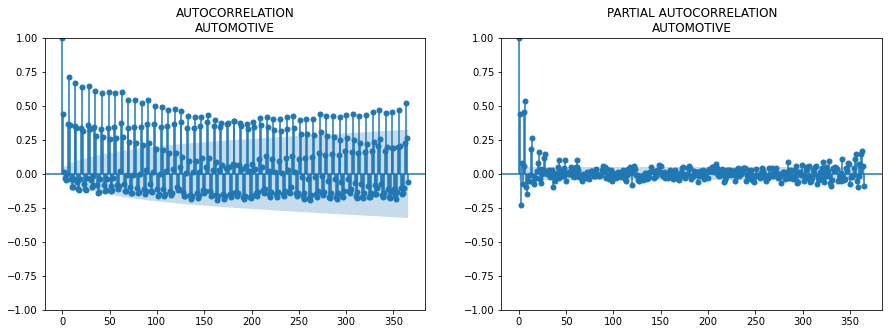

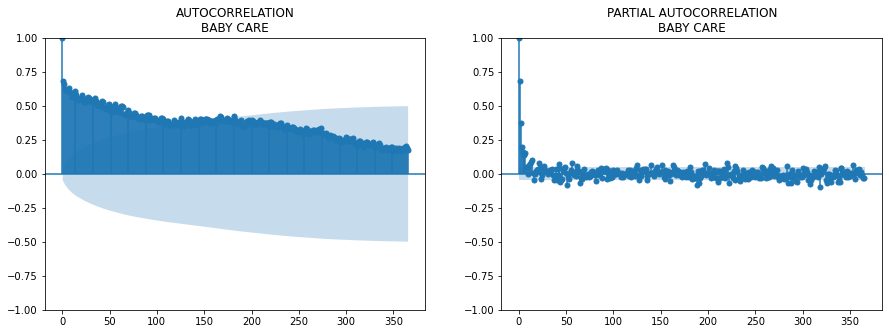

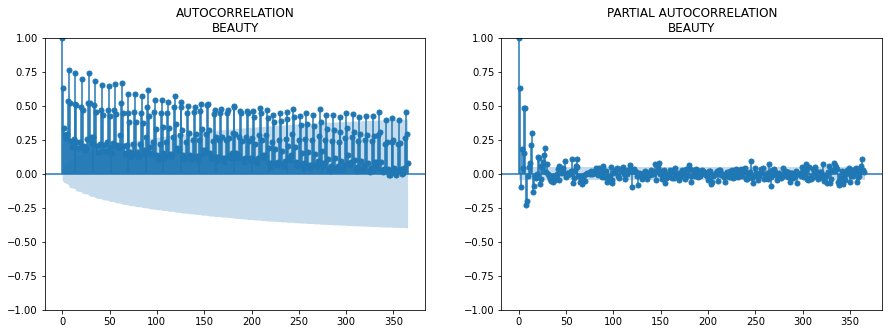

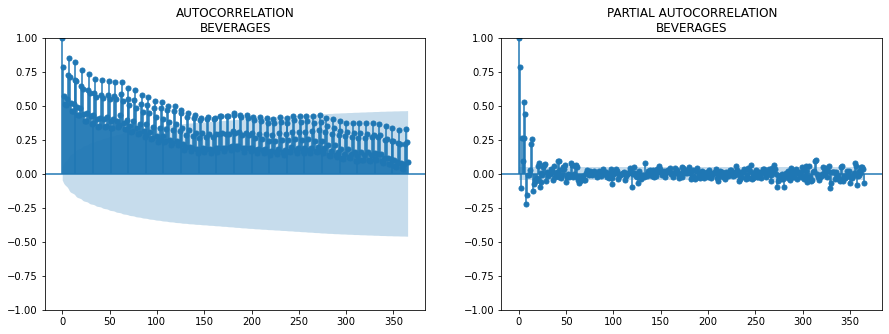

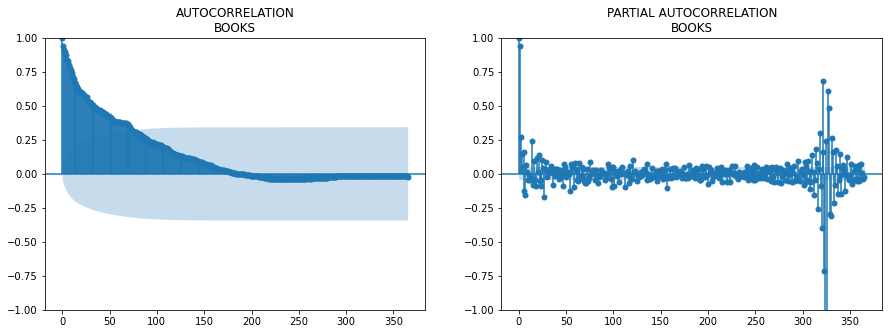

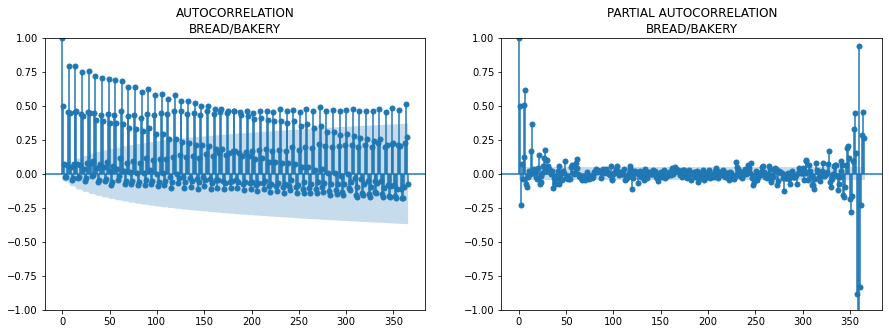

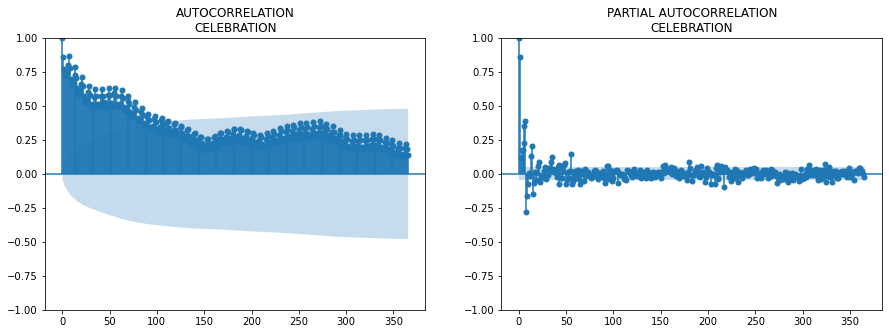

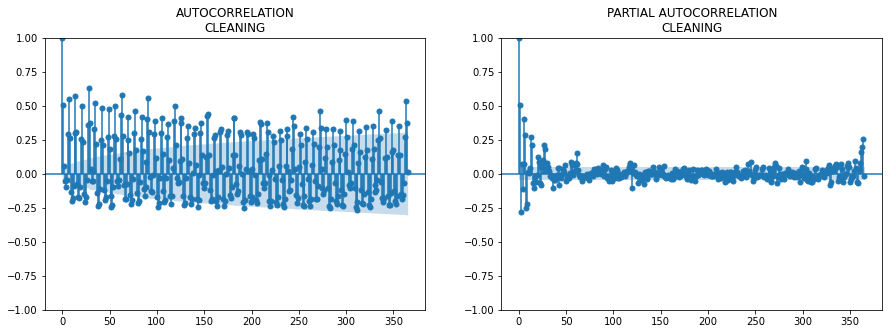

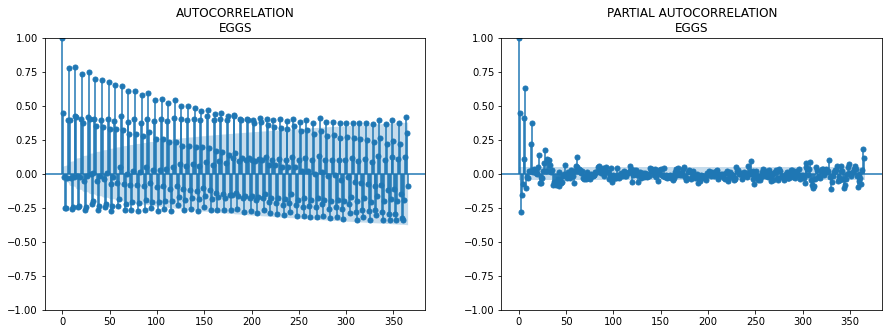

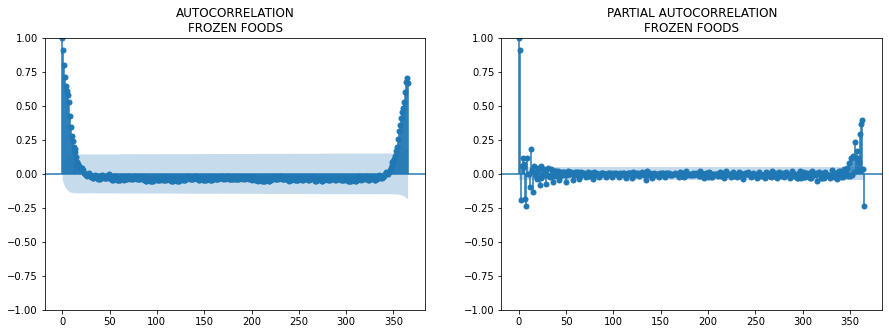

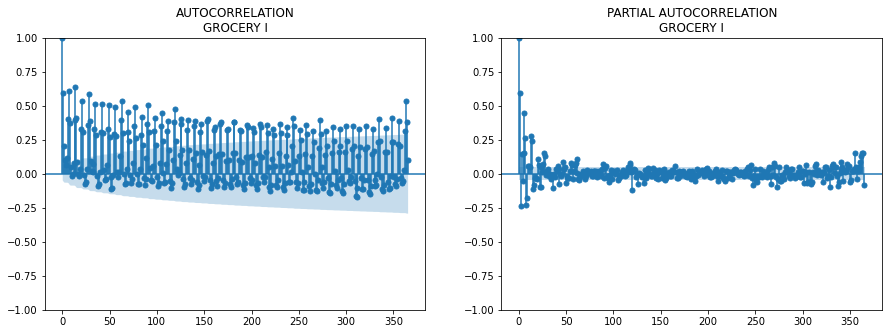

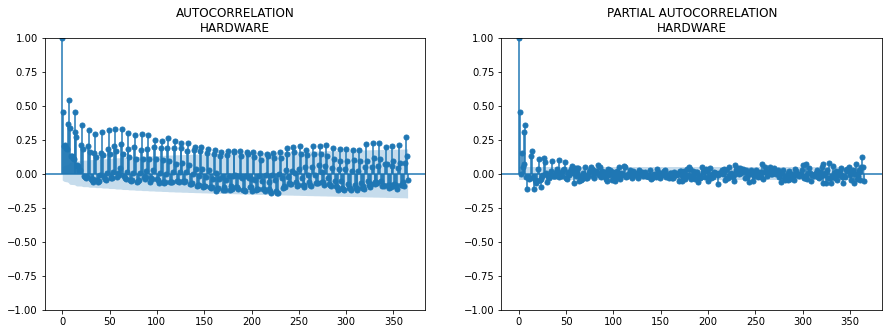

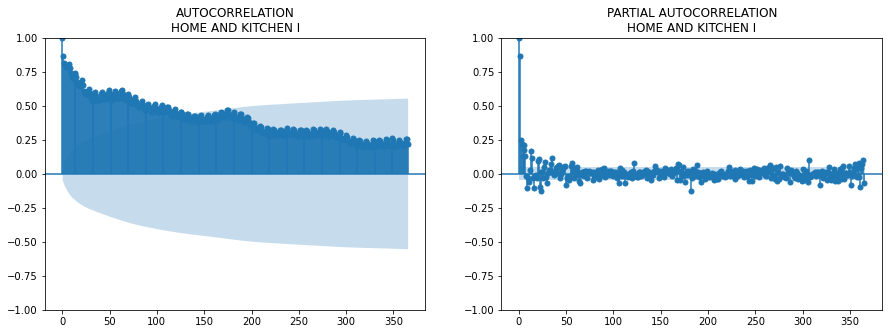

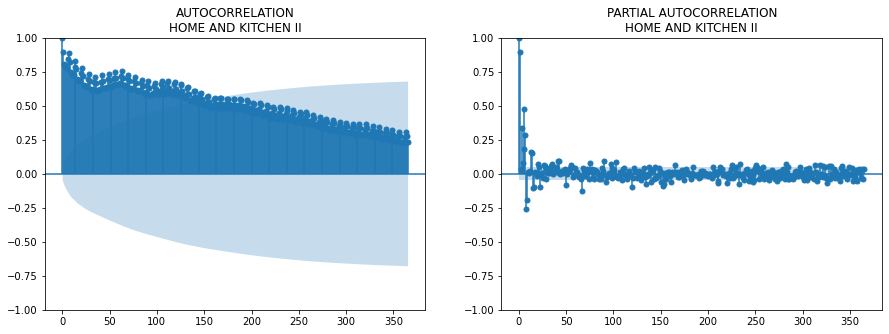

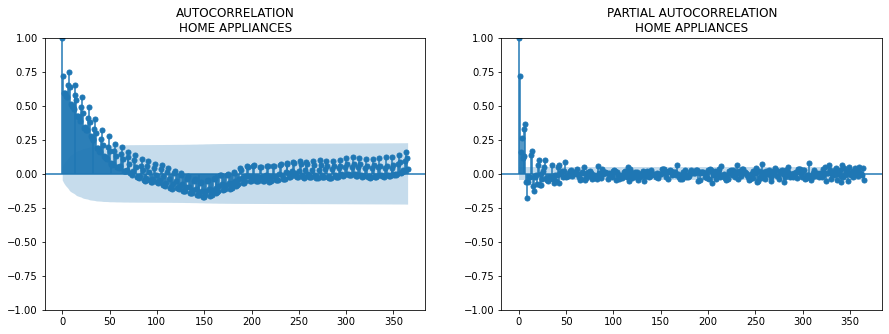

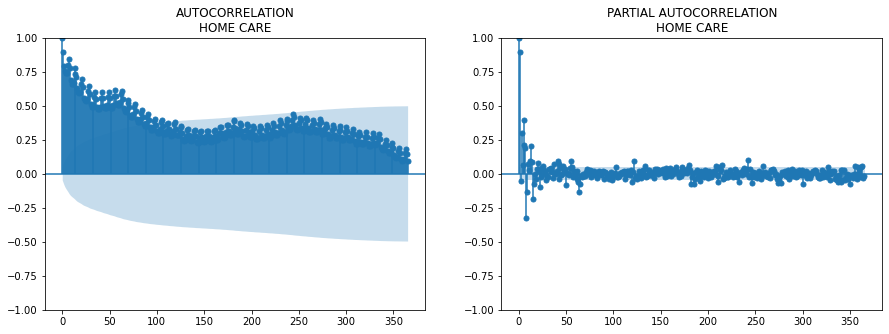

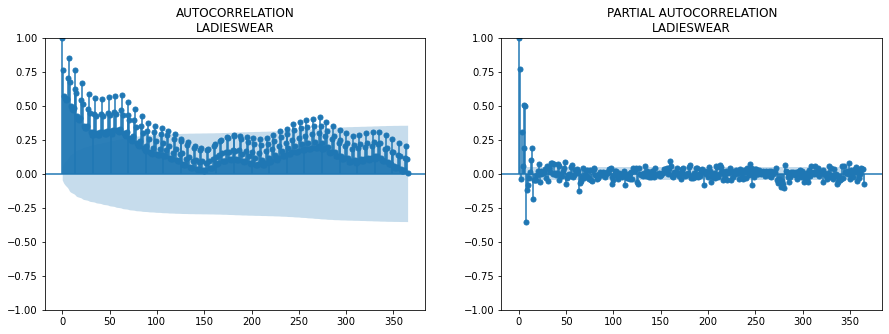

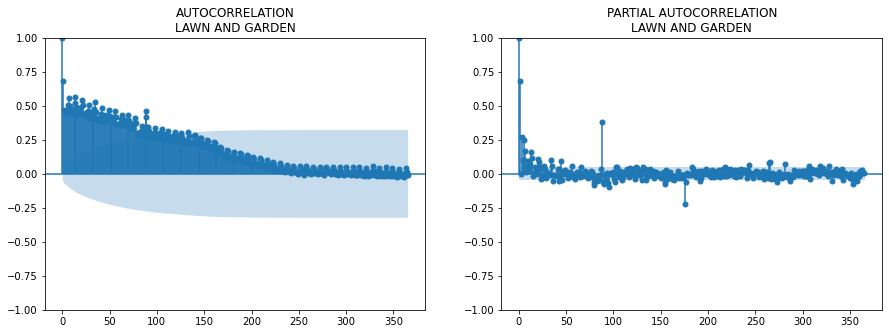

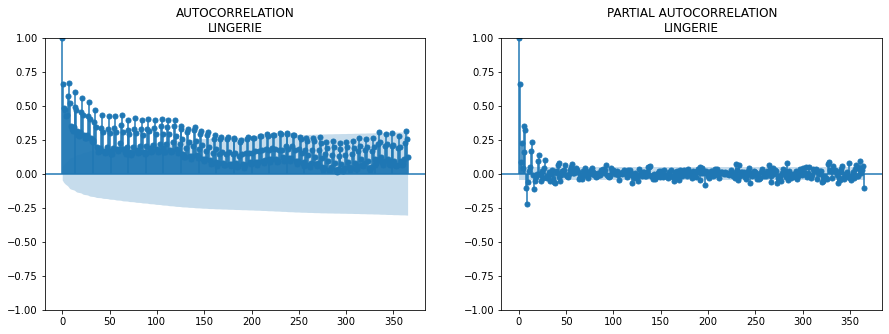

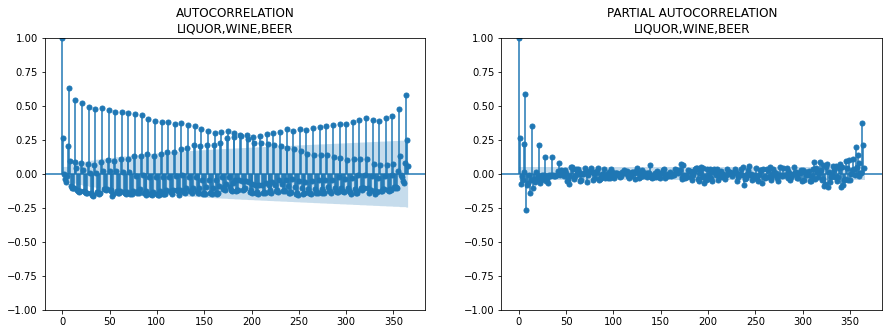

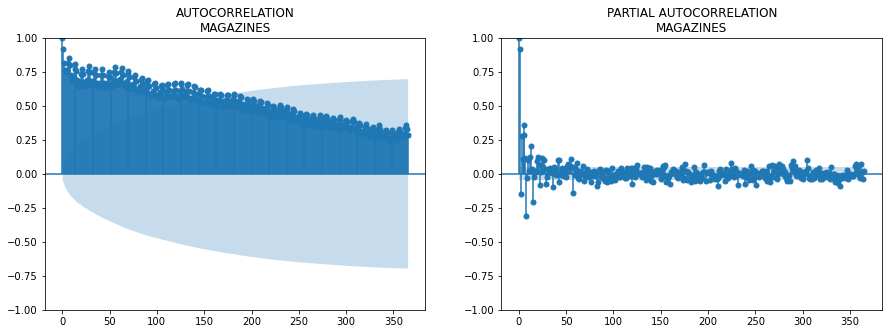

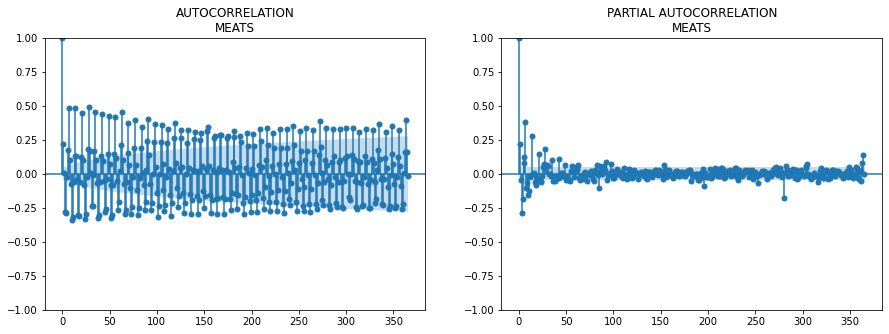

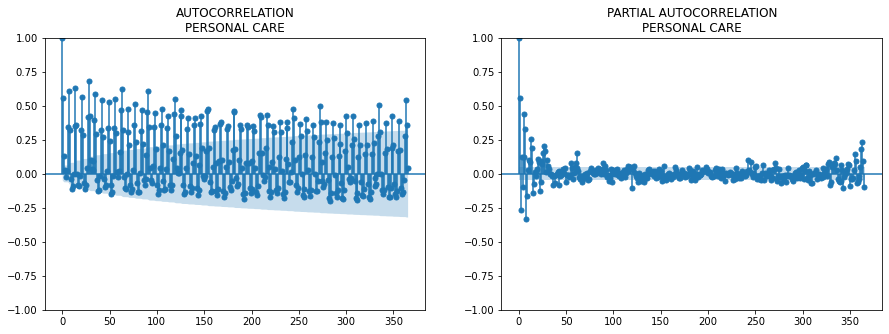

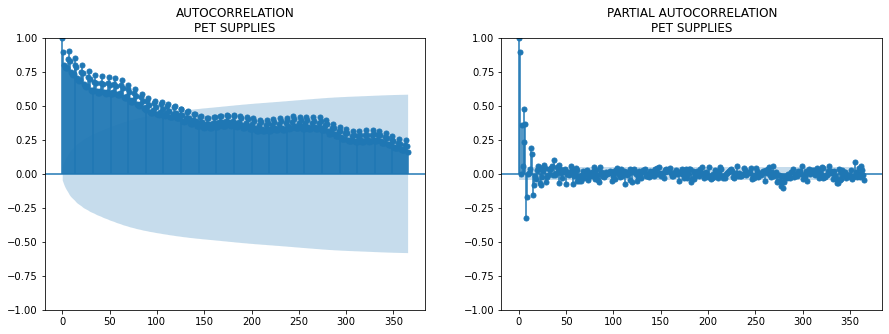

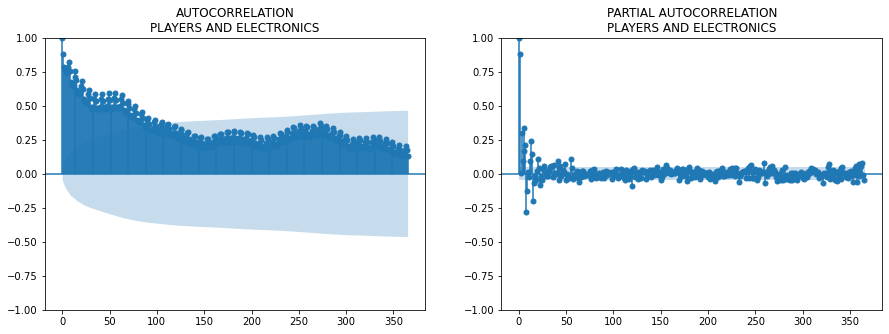

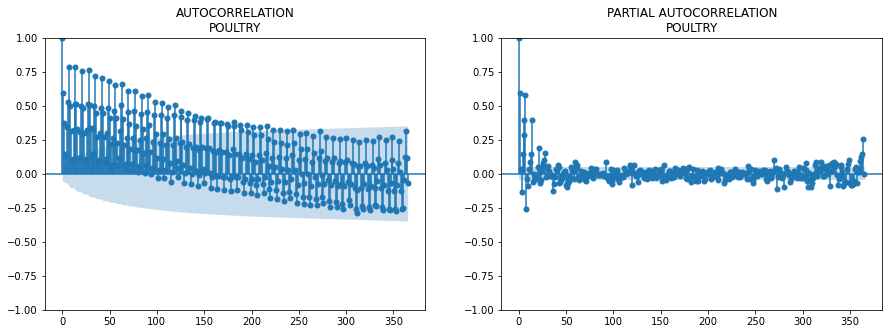

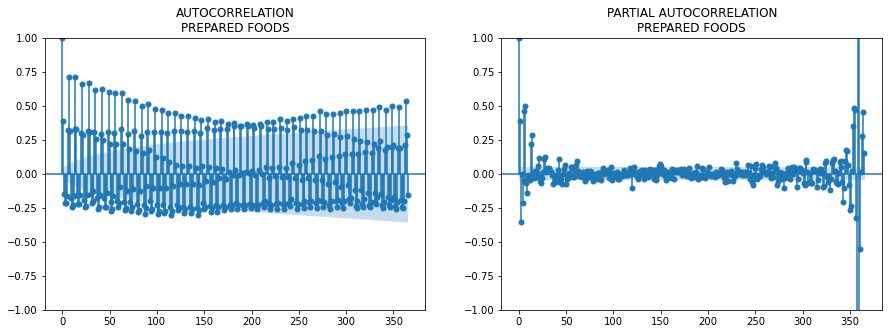

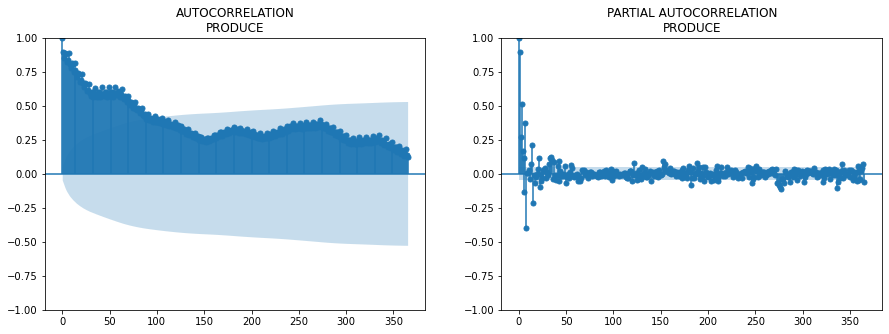

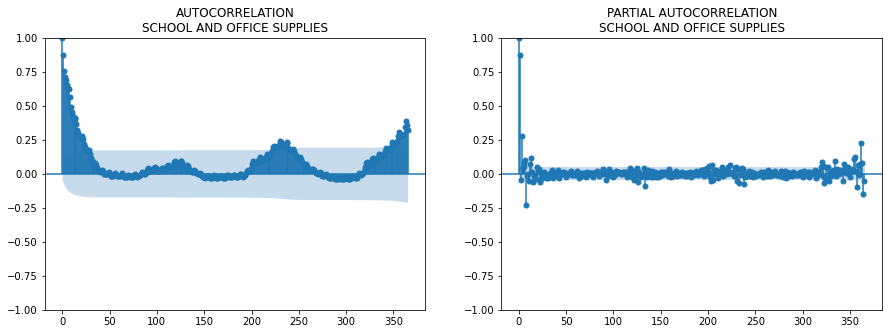

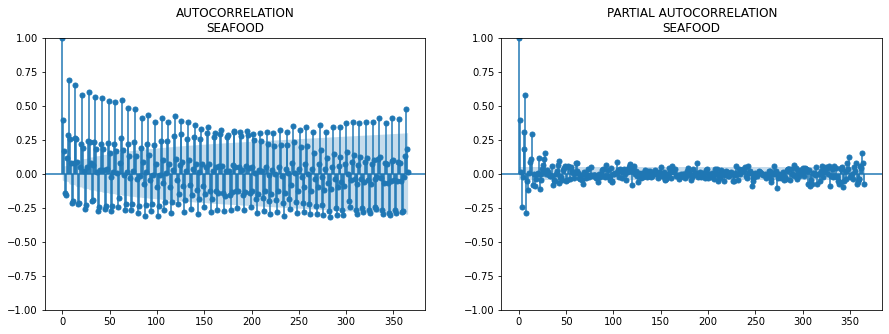

In [3]:
a = train[(train.sales.notnull())].groupby(["date", "family"]).sales.mean().reset_index().set_index("date")
for num, i in enumerate(a.family.unique()):
    try:
        fig, ax = plt.subplots(1,2,figsize=(15,5))
        temp = a[(a.family == i)]#& (a.sales.notnull())
        sm.graphics.tsa.plot_acf(temp.sales, lags=365, ax=ax[0], title = "AUTOCORRELATION\n" + i)
        sm.graphics.tsa.plot_pacf(temp.sales, lags=365, ax=ax[1], title = "PARTIAL AUTOCORRELATION\n" + i)
    except:
        pass

In [4]:
a = train[train.year.isin([2016,2017])].groupby(["year", "day_of_year"]).sales.mean().reset_index()
px.line(a, x = "day_of_year", y = "sales", color = "year", title = "Average sales for 2016 and 2017")

In [5]:
a = train.sort_values(["store_nbr", "family", "date"])
for i in [20, 30, 45, 60, 90, 120, 365, 730]:
    a["SMA"+str(i)+"_sales_lag16"] = a.groupby(["store_nbr", "family"]).rolling(i).sales.mean().shift(16).values
    a["SMA"+str(i)+"_sales_lag30"] = a.groupby(["store_nbr", "family"]).rolling(i).sales.mean().shift(30).values
    a["SMA"+str(i)+"_sales_lag60"] = a.groupby(["store_nbr", "family"]).rolling(i).sales.mean().shift(60).values
print("Correlation")
a[["sales"]+a.columns[a.columns.str.startswith("SMA")].tolist()].corr()

Correlation


sales  SMA20_sales_lag16  SMA20_sales_lag30  \
sales               1.000000           0.905956           0.891138   
SMA20_sales_lag16   0.905956           1.000000           0.986054   
SMA20_sales_lag30   0.891138           0.986054           1.000000   
SMA20_sales_lag60   0.870018           0.948179           0.962302   
SMA30_sales_lag16   0.905079           0.997382           0.994385   
SMA30_sales_lag30   0.892388           0.983444           0.997382   
SMA30_sales_lag60   0.867134           0.950992           0.963142   
SMA45_sales_lag16   0.906339           0.992882           0.996129   
SMA45_sales_lag30   0.894101           0.981329           0.992882   
SMA45_sales_lag60   0.867223           0.951769           0.965260   
SMA60_sales_lag16   0.906763           0.989575           0.993485   
SMA60_sales_lag30   0.893300           0.980859           0.989575   
SMA60_sales_lag60   0.867265           0.950678           0.964963   
SMA90_sales_lag16   0.904943           0.985697           0.989326   
SMA90_sales_lag30   0.891900           0.977599           0.985697   
SMA90_sales_lag60   0.864435           0.947984           0.961864   
SMA120_sales_lag16  0.902408           0.981231           0.985464   
SMA120_sales_lag30  0.888995           0.974076           0.981231   
SMA120_sales_lag60  0.862825           0.945232           0.959348   
SMA365_sales_lag16  0.901313           0.972034           0.973381   
SMA365_sales_lag30  0.890902           0.969831           0.972034   
SMA365_sales_lag60  0.866331           0.948019           0.960043   
SMA730_sales_lag16  0.906352           0.976704           0.976323   
SMA730_sales_lag30  0.892459           0.975832           0.976704   
SMA730_sales_lag60  0.862171           0.947727           0.963057   

                    SMA20_sales_lag60  SMA30_sales_lag16  SMA30_sales_lag30  \
sales                        0.870018           0.905079           0.892388   
SMA20_sales_lag16            0.948179           0.997382           0.983444   
SMA20_sales_lag30            0.962302           0.994385           0.997382   
SMA20_sales_lag60            1.000000           0.959008           0.975891   
SMA30_sales_lag16            0.959008           1.000000           0.991979   
SMA30_sales_lag30            0.975891           0.991979           1.000000   
SMA30_sales_lag60            0.997382           0.961222           0.976133   
SMA45_sales_lag16            0.976925           0.997405           0.997697   
SMA45_sales_lag30            0.988930           0.988814           0.997405   
SMA45_sales_lag60            0.992882           0.962742           0.977028   
SMA60_sales_lag16            0.986943           0.994237           0.996669   
SMA60_sales_lag30            0.992628           0.987208           0.994237   
SMA60_sales_lag60            0.989575           0.961929           0.977100   
SMA90_sales_lag16            0.989728           0.990230           0.992766   
SMA90_sales_lag30            0.989859           0.983691           0.990230   
SMA90_sales_lag60            0.985697           0.959093           0.974194   
SMA120_sales_lag16           0.988375           0.986027           0.989526   
SMA120_sales_lag30           0.987734           0.979861           0.986027   
SMA120_sales_lag60           0.981231           0.956601           0.971354   
SMA365_sales_lag16           0.974868           0.975909           0.977066   
SMA365_sales_lag30           0.974208           0.973839           0.975909   
SMA365_sales_lag60           0.972034           0.959021           0.971238   
SMA730_sales_lag16           0.975987           0.978761           0.978497   
SMA730_sales_lag30           0.976151           0.978108           0.978761   
SMA730_sales_lag60           0.976704           0.959860           0.975640   

                    SMA30_sales_lag60  SMA45_sales_lag16  SMA45_sales_lag30  \
sales                        0.867134           0.906339           0

## Model 1: Simple Moving Average

In [102]:
# prep this for final model selection later

final_modelname = []
final_rmse = []

In [103]:
data_sma = train.groupby('date').agg({'sales': 'sum'})
data_sma['type'] = 'train'
data_sma.head()

sales   type
date                            
2013-01-01    2511.618999  train
2013-01-02  496092.417944  train
2013-01-03  361461.231124  train
2013-01-04  354459.677093  train
2013-01-05  477350.121229  train

In [104]:
data_sma_test = test.groupby('date').agg({'sales': 'sum'})
data_sma_test['type'] = 'test'
data_sma = data_sma.append(data_sma_test)

<ipython-input-104-a600af7a8c54>:3: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [105]:
def SMA(data, period=30, column='sales'):
    return data[column].rolling(window=period).mean()

In [106]:
# create prediction with SMA with periods of [2, 3, 7, 14, 30]
data_sma['SMA_2'] = SMA(data_sma, 2)
data_sma['SMA_3'] = SMA(data_sma, 3)
data_sma['SMA_7'] = SMA(data_sma, 7)
data_sma['SMA_14'] = SMA(data_sma, 14)
data_sma['SMA_30'] = SMA(data_sma, 30)

In [107]:
smas = ['SMA_2', 'SMA_3', 'SMA_7', 'SMA_14', 'SMA_30']
SMA_rmse = []

for s in smas:
    rms = metrics.mean_squared_error(data_sma[data_sma['type'] == 'test']['sales'], data_sma[data_sma['type'] == 'test'][s], squared=True)
    SMA_rmse.append(rms)
    # final model selection
    final_modelname.append(s)
    final_rmse.append(rms)

SMA_models_evaluation = pd.DataFrame(list(zip(smas, SMA_rmse)), columns=['period', 'RMSE'])
print(SMA_models_evaluation[SMA_models_evaluation['RMSE'] == SMA_models_evaluation['RMSE'].min()])
SMA_models_evaluation

  period          RMSE
0  SMA_2  3.803042e+09


period          RMSE
0   SMA_2  3.803042e+09
1   SMA_3  7.273420e+09
2   SMA_7  1.100230e+10
3  SMA_14  1.384525e+10
4  SMA_30  1.169549e+10

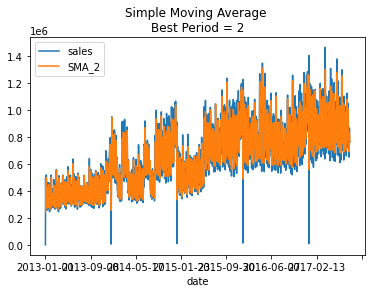

In [67]:
data_sma[["sales", "SMA_2"]].plot(title = "Simple Moving Average \nBest Period = 2")
plt.show()

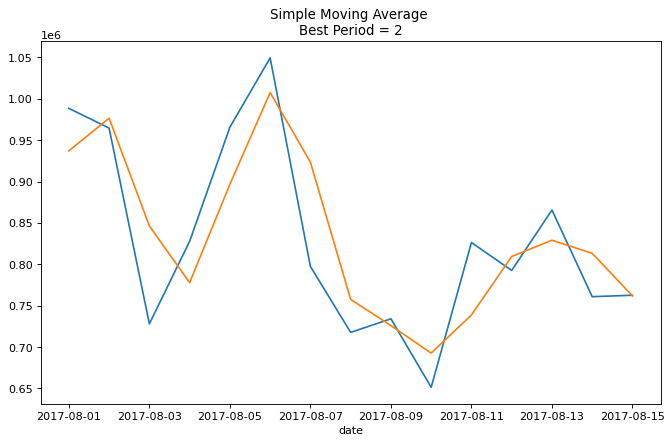

In [68]:
figure(figsize=(10, 6), dpi=80)

data_sma[data_sma['type'] == 'test']["sales"].plot(title = "Simple Moving Average \nBest Period = 2")
data_sma[data_sma['type'] == 'test']["SMA_2"].plot()
plt.savefig('figures/sma_2.png')
plt.show()

## Model 2: Exponential Moving Average

In [108]:
data_ema = train.groupby('date').agg({'sales': 'sum'})
data_ema['type'] = 'train'
data_ema_test = test.groupby('date').agg({'sales': 'sum'})
data_ema_test['type'] = 'test'
data_ema = data_ema.append(data_ema_test)

<ipython-input-108-32c65ec69344>:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [110]:
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
emas = ['alpha_0.95', 'alpha_0.9', 'alpha_0.8', 'alpha_0.7', 'alpha_0.5']

for i in range(len(alphas)):
    a = alphas[i]
    col = emas[i]
    
    data_ema[col] = data_ema[['sales']].ewm(alpha=a).mean().sales

In [111]:
EMA_rmse = []

for e in emas:
    rms = metrics.mean_squared_error(data_ema[data_ema['type'] == 'test']['sales'], data_ema[data_ema['type'] == 'test'][e], squared=True)
    EMA_rmse.append(rms)
    # final model selection
    final_modelname.append('EMA_'+e)
    final_rmse.append(rms)

EMA_models_evaluation = pd.DataFrame(list(zip(emas, EMA_rmse)), columns=['alpha', 'RMSE'])
print(EMA_models_evaluation[EMA_models_evaluation['RMSE'] == EMA_models_evaluation['RMSE'].min()])
EMA_models_evaluation

        alpha          RMSE
0  alpha_0.95  3.720407e+07


alpha          RMSE
0  alpha_0.95  3.720407e+07
1   alpha_0.9  1.460442e+08
2   alpha_0.8  5.673802e+08
3   alpha_0.7  1.250687e+09
4   alpha_0.5  3.364997e+09

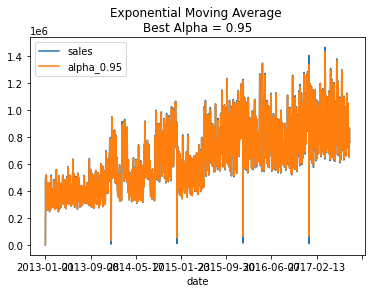

In [73]:
data_ema[["sales", "alpha_0.95"]].plot(title='Exponential Moving Average \nBest Alpha = 0.95')
plt.show()

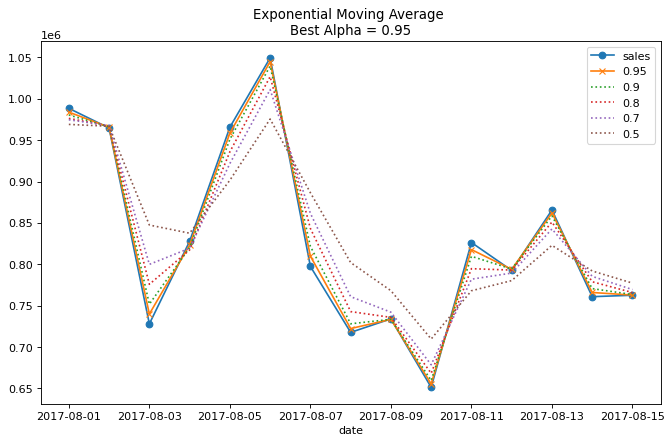

In [74]:
figure(figsize=(10, 6), dpi=80)

data_ema[data_ema['type'] == 'test']["sales"].plot(title = "Exponential Moving Average \nBest Alpha = 0.95", marker='o')
data_ema[data_ema['type'] == 'test']["alpha_0.95"].plot(label='0.95', marker='x')
data_ema[data_ema['type'] == 'test']["alpha_0.9"].plot(label='0.9', linestyle=':')
data_ema[data_ema['type'] == 'test']["alpha_0.8"].plot(label='0.8', linestyle=':')
data_ema[data_ema['type'] == 'test']["alpha_0.7"].plot(label='0.7', linestyle=':')
data_ema[data_ema['type'] == 'test']["alpha_0.5"].plot(label='0.5', linestyle=':')
plt.legend()
plt.savefig('figures/ema_0.95.png')
plt.show()

## Model 3. FB Prophet

In [112]:
data_prophet = train.groupby('date').agg({'sales': 'sum'})
data_prophet = data_prophet.reset_index()
data_prophet.columns = ['ds', 'y']

In [113]:
model=Prophet()

In [114]:
model.fit(data_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\cchan\.conda\envs\time_series\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [115]:
# define the period for which we want a prediction
future = list(test['date'].unique())
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds'] = pd.to_datetime(future['ds'])

In [116]:
prophet_forecast = model.predict(future)

C:\Users\cchan\.conda\envs\time_series\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\cchan\.conda\envs\time_series\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



          ds           yhat     yhat_lower    yhat_upper
0 2017-08-01  778902.339678  639763.672769  9.123386e+05
1 2017-08-02  798944.844731  653373.124210  9.395631e+05
2 2017-08-03  707924.717808  573998.257744  8.425772e+05
3 2017-08-04  778512.036790  631843.216854  9.101851e+05
4 2017-08-05  967410.004154  832887.449642  1.116469e+06


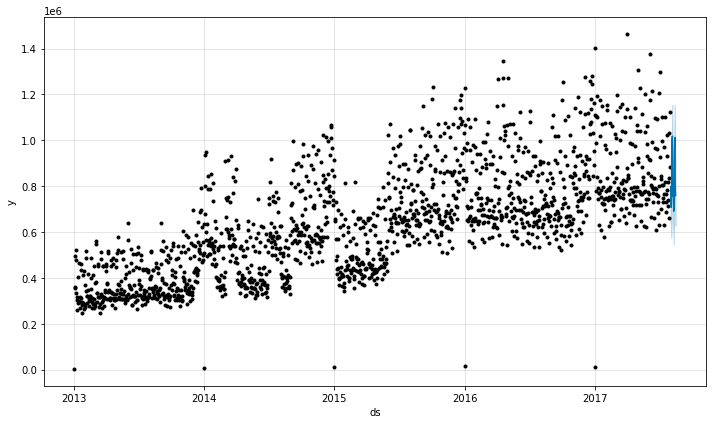

In [117]:
print(prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(prophet_forecast)
plt.show()

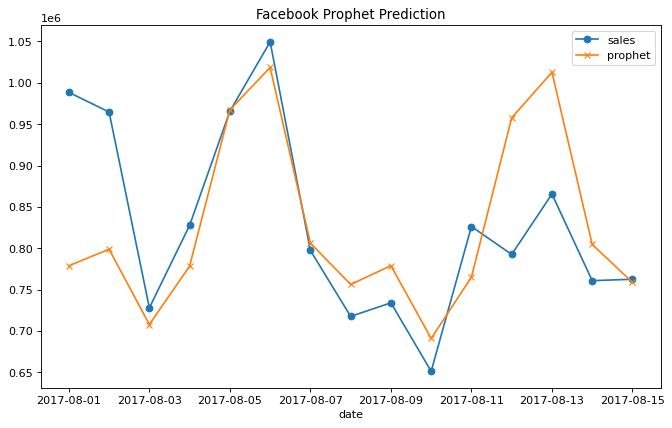

In [81]:
figure(figsize=(10, 6), dpi=80)

data_ema[data_ema['type'] == 'test']['sales'].plot(title='Facebook Prophet Prediction', marker='o')
prophet_forecast['yhat'].plot(label='prophet', marker='x')
plt.legend()
plt.savefig('figures/prophet.png')
plt.show()

In [118]:
prophet_rms = metrics.mean_squared_error(data_ema[data_ema['type'] == 'test']['sales'], prophet_forecast['yhat'], squared=True)

# final model selection
final_modelname.append('Facebook Prophet')
final_rmse.append(prophet_rms)

print(prophet_rms)

8999092425.752182


## Model 4: SK Learn Algorithms

In [119]:
# creating new dataframe from sales column
X_train = train.groupby('date').agg({'sales': 'sum'})
# inserting new column with yesterday's sales values
X_train['yesterday'] = X_train['sales'].shift()
# inserting another column with difference between yesterday and day before yesterday's sales values.
X_train['yesterday_Diff'] = X_train['yesterday'].diff()
# dropping NAs
X_train = X_train.dropna()

# creating new dataframe from sales column
X_test = test.groupby('date').agg({'sales': 'sum'})
# inserting new column with yesterday's sales values
X_test['yesterday'] = X_test['sales'].shift()
# inserting another column with difference between yesterday and day before yesterday's sales values.
X_test['yesterday_Diff'] = X_test['yesterday'].diff()
# dropping NAs
X_test = X_test.dropna()

In [120]:
y_train = X_train['sales']
X_train = X_train.loc[:,X_train.columns!='sales']
y_test = X_test['sales']
X_test = X_test.loc[:,X_test.columns!='sales']

In [121]:
# LR - Linear Regression
# RF - Ensemble method - collection of many decision trees
# SVR - kernel = linear

models = {'LR': LinearRegression(), 
           'RF': RandomForestRegressor(n_estimators = 10), 
           'SVR': SVR(gamma='auto')}

# Evaluate each model in turn
results = []
names = []
rmses_sklearn = []

for name, model in models.items():
    # final model selection
    final_modelname.append(name)
    
    names.append(name)
    name = model
    name.fit(X_train, y_train)
    
    forecast = name.predict(X_test)
    results.append(forecast)
    
    rmse = metrics.mean_squared_error(y_test, forecast, squared=True)
    rmses_sklearn.append(rmse)
    
    # final model selection
    final_rmse.append(rmse)

In [122]:
y_test = pd.DataFrame(y_test)

In [123]:
for i in range(len(names)):
    name_of_model = names[i]
    forecast = results[i]
    
    y_test[name_of_model] = forecast

In [124]:
sklearn_evaluation = pd.DataFrame(list(zip(names, rmses_sklearn)), columns=['Model Name', 'RMSE'])
sklearn_evaluation

Model Name          RMSE
0         LR  1.384171e+10
1         RF  1.719894e+10
2        SVR  4.127169e+10

In [125]:
y_test

sales             LR             RF            SVR
date                                                                 
2017-08-03  7.280685e+05  882212.092733  557513.511200  630710.572888
2017-08-04  8.277757e+05  690987.387656  839383.469418  630710.572888
2017-08-05  9.656937e+05  786708.100798  700563.508988  630710.572888
2017-08-06  1.049559e+06  892884.313414  756206.607122  630710.572888
2017-08-07  7.974650e+05  952701.432435  846421.506460  630710.572888
2017-08-08  7.177663e+05  742282.524721  720212.780709  630710.572888
2017-08-09  7.341397e+05  692870.681394  758671.623513  630710.572888
2017-08-10  6.513869e+05  711097.545316  596840.334466  630710.572888
2017-08-11  8.263737e+05  642710.365859  726782.922774  630710.572888
2017-08-12  7.926305e+05  790276.107440  925624.625392  630710.572888
2017-08-13  8.656397e+05  752053.481015  855969.013660  630710.572888
2017-08-14  7.609224e+05  813573.707758  825003.117650  630710.572888
2017-08-15  7.626619e+05  723823.482567  777738.488192  630710.572888

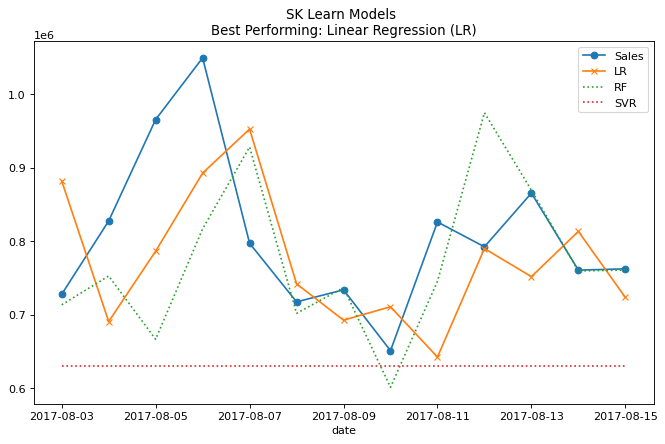

In [100]:
figure(figsize=(10, 6), dpi=80)

y_test['sales'].plot(label='Sales', marker='o')
y_test['LR'].plot(label='LR', marker='x')
y_test['RF'].plot(label='RF', linestyle=':')
y_test['SVR'].plot(label='SVR', linestyle=':')

plt.legend()
plt.savefig('figures/SKLearn Models.png')
plt.title('SK Learn Models \nBest Performing: Linear Regression (LR)')
plt.show()

# Final Model Selection

In [126]:
models_final = pd.DataFrame(list(zip(final_modelname, final_rmse)), columns=['Model Name', 'Root Mean Squared Error'])
models_final.sort_values('Root Mean Squared Error', ascending=True)

Model Name  Root Mean Squared Error
5     EMA_alpha_0.95             3.720407e+07
6      EMA_alpha_0.9             1.460442e+08
7      EMA_alpha_0.8             5.673802e+08
8      EMA_alpha_0.7             1.250687e+09
9      EMA_alpha_0.5             3.364997e+09
0              SMA_2             3.803042e+09
1              SMA_3             7.273420e+09
10  Facebook Prophet             8.999092e+09
2              SMA_7             1.100230e+10
4             SMA_30             1.169549e+10
11                LR             1.384171e+10
3             SMA_14             1.384525e+10
12                RF             1.719894e+10
13               SVR             4.127169e+10

Exponential Moving Average has the best performance amongst all, but it can perform the best within the shortest timeframe, given it's using moving average, it's harder to predict dates that are further out with more accuracy. This is when Facebook Prophet performance shines.

# Final Prediction

1. Facebook Prophet

In [149]:
# get final test data (date range)

final_test = pd.read_csv('data/processed/final_test.csv')
final_test = final_test.iloc[:,4:]
final_test = final_test.set_index('id')
final_test = final_test['date'].unique()

<ipython-input-151-03c4f5336d76>:3: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\cchan\.conda\envs\time_series\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\cchan\.conda\envs\time_series\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\cchan\.conda\envs\time_series\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



          ds          yhat     yhat_lower    yhat_upper
0 2017-08-16  7.834548e+05  636648.826353  9.081119e+05
1 2017-08-17  6.988369e+05  552475.307557  8.476869e+05
2 2017-08-18  7.772160e+05  637807.825809  9.158564e+05
3 2017-08-19  9.723300e+05  833373.447980  1.109632e+06
4 2017-08-20  1.031077e+06  886446.367957  1.177184e+06


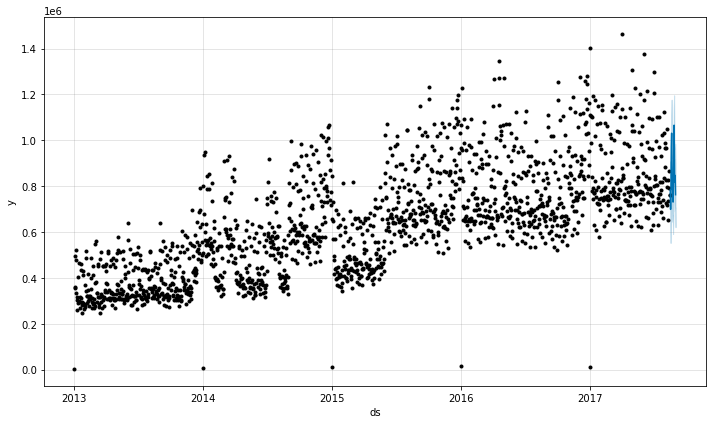

In [151]:
data_prophet = train.groupby('date').agg({'sales': 'sum'})
data_prophet_faketestearlier = test.groupby('date').agg({'sales': 'sum'})
data_prophet = data_prophet.append(data_prophet_faketestearlier)
data_prophet = data_prophet.reset_index()
data_prophet.columns = ['ds', 'y']
model=Prophet()
model.fit(data_prophet)
# define the period for which we want a prediction
future = final_test
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds'] = pd.to_datetime(future['ds'])
prophet_forecast = model.predict(future)
print(prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(prophet_forecast)
plt.show()

In [154]:
prophet_forecast = pd.DataFrame(prophet_forecast)
prophet_forecast = prophet_forecast.set_index('ds')

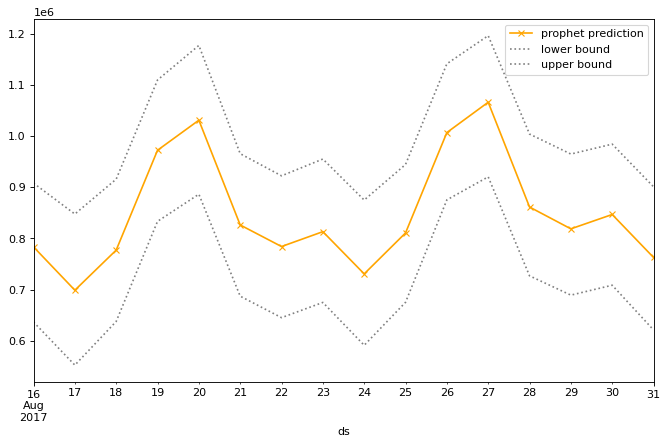

In [155]:
figure(figsize=(10, 6), dpi=80)

prophet_forecast['yhat'].plot(label='prophet prediction', marker='x', color='orange')
prophet_forecast['yhat_lower'].plot(label='lower bound', linestyle=':', color='grey')
prophet_forecast['yhat_upper'].plot(label='upper bound', linestyle=':', color='grey')

plt.legend()
plt.savefig('figures/prophet_finalprediction.png')
plt.show()

In [156]:
prophet_forecast.to_csv('data/output/prophet_forecast.csv')